In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mat73

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
data_path = '/content/drive/MyDrive/RL Course Project/indiapinedataset.pkl'

In [4]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import *
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
import mat73
import numpy as np
import pickle

In [5]:
data_path='/content/drive/MyDrive/RL Course Project/indiapinedataset.pkl'

In [6]:
class HSIDataset(Dataset):
    def __init__(self, dataset, split="train", transform=None):
        if split == "train":
            self.x = dataset['x_train']
            self.y = dataset['y_train']
        elif split == "val":
            self.x = dataset['x_val']
            self.y = dataset['y_val']
        else:
            self.x = dataset['x_test']
            self.y = dataset['y_test']
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        image = self.x[idx]
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        image = torch.Tensor(image)
        label = torch.Tensor(label)
        return image, label

In [7]:
class HSIClassification(nn.Module):
  def __init__(self, n_bands=200, n_classes=16):
    super(HSIClassification, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_bands, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Dropout(0.2),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.BatchNorm1d(50),
            nn.Dropout(0.2),
            nn.Linear(50, n_classes),
        )
    
  def forward(self, x, band_mask=None):
    x = self.flatten(x)
    if band_mask is not None:
      x = x*band_mask
    x = self.linear_relu_stack(x)
    return x

In [8]:
with open(data_path, 'rb') as handle:
    dataset = pickle.load(handle)
training_data = HSIDataset(dataset)
test_data = HSIDataset(dataset, split="val") #val is test and viceversa
val_data = HSIDataset(dataset, split="test")
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

In [9]:
model = HSIClassification()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

In [10]:
epoch_loss = []
train_accuracy = []
test_accuracy = []
best_test = 0
for epoch in range(3000):
  batch_loss = []
  accuracy = 0
  model.train()
  for x, y in train_dataloader:
    optimizer.zero_grad()

    output = model(x)
    loss = loss_fn(output, y)
    accuracy += (nn.Softmax(dim=1)(output).argmax(1) == y.argmax(1)).float().sum()
    batch_loss.append(loss.item())

    loss.backward()
    optimizer.step()
    
  accuracy_test = 0
  model.eval()
  for x, y in test_dataloader:
    output = model(x)
    accuracy_test += (nn.Softmax(dim=1)(output).argmax(1) == y.argmax(1)).float().sum()
  if accuracy_test > best_test:
    best_test = accuracy_test
    torch.save(model.state_dict(), "best_model_baseline.pth")
  loss = sum(batch_loss)/len(batch_loss)
  epoch_loss.append(loss)
  train_acc = 100 * accuracy.item() / len(training_data)
  train_accuracy.append(train_acc)
  test_acc = 100 * accuracy_test.item() / len(test_data)
  test_accuracy.append(test_acc)
  print(f'[{epoch+1}/3000] Average Loss: {np.round(loss, 4)}\t Train Accuracy: {np.round(train_acc, 2)}%\t Val Accuracy: {np.round(test_acc, 2)}%')

[1/3000] Average Loss: 2.4227	 Train Accuracy: 24.82%	 Val Accuracy: 33.97%
[2/3000] Average Loss: 1.8915	 Train Accuracy: 45.32%	 Val Accuracy: 15.31%
[3/3000] Average Loss: 1.5048	 Train Accuracy: 46.76%	 Val Accuracy: 44.98%
[4/3000] Average Loss: 1.5476	 Train Accuracy: 47.96%	 Val Accuracy: 22.49%
[5/3000] Average Loss: 1.5508	 Train Accuracy: 51.8%	 Val Accuracy: 36.36%
[6/3000] Average Loss: 1.4984	 Train Accuracy: 53.12%	 Val Accuracy: 14.83%
[7/3000] Average Loss: 1.3162	 Train Accuracy: 52.64%	 Val Accuracy: 33.49%
[8/3000] Average Loss: 1.5047	 Train Accuracy: 52.76%	 Val Accuracy: 18.66%
[9/3000] Average Loss: 1.4033	 Train Accuracy: 54.92%	 Val Accuracy: 19.62%
[10/3000] Average Loss: 1.3201	 Train Accuracy: 54.44%	 Val Accuracy: 51.67%
[11/3000] Average Loss: 1.3801	 Train Accuracy: 55.4%	 Val Accuracy: 4.78%
[12/3000] Average Loss: 1.5466	 Train Accuracy: 53.84%	 Val Accuracy: 12.44%
[13/3000] Average Loss: 1.7213	 Train Accuracy: 50.12%	 Val Accuracy: 12.44%
[14/3000] A

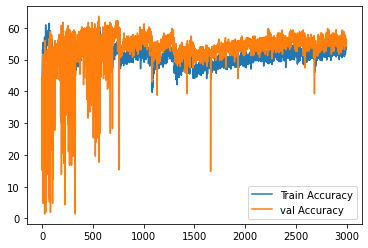

In [11]:
plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(test_accuracy, label="val Accuracy")
plt.legend()
plt.show()

In [12]:
print(f"Best Val Accuracy (All Bands): {np.round(100 * best_test.item() / len(test_data), 2)}%")

Best Val Accuracy (All Bands): 63.64%


In [13]:
accuracy_test = 0
model.eval()
model.load_state_dict(torch.load('/content/best_model_baseline.pth'))
for x, y in val_dataloader:
  output = model(x)
  accuracy_test += (nn.Softmax(dim=1)(output).argmax(1) == y.argmax(1)).float().sum()

test_acc = 100 * accuracy_test.item() / len(val_data)
print(f'Test Accuracy: {np.round(test_acc, 2)}%')

Test Accuracy: 62.27%


Random band mask

In [ ]:
model = HSIClassification()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
import random

In [ ]:
epoch_loss = []
train_accuracy = []
test_accuracy = []
best_test = 0
idx = random.sample(range(0, 200), 30)
band_mask = torch.zeros((1, 200))
band_mask[0, idx] = 1
band_mask = torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
for epoch in range(1000):
  batch_loss = []
  accuracy = 0
  model.train()
  for x, y in train_dataloader:
    optimizer.zero_grad()

    output = model(x, band_mask)
    loss = loss_fn(output, y)
    accuracy += (nn.Softmax(dim=1)(output).argmax(1) == y.argmax(1)).float().sum()
    batch_loss.append(loss.item())

    loss.backward()
    optimizer.step()
  accuracy_test = 0
  model.eval()
  for x, y in test_dataloader:
    output = model(x, band_mask)
    accuracy_test += (nn.Softmax(dim=1)(output).argmax(1) == y.argmax(1)).float().sum()
  if accuracy_test > best_test:
    best_test = accuracy_test
    torch.save(model.state_dict(), f"best_model_random_{int(band_mask.sum().item())}_bands.pth")
  loss = sum(batch_loss)/len(batch_loss)
  epoch_loss.append(loss)
  train_acc = 100 * accuracy.item() / len(training_data)
  train_accuracy.append(train_acc)
  test_acc = 100 * accuracy_test.item() / len(test_data)
  test_accuracy.append(test_acc)
  print(f'[{epoch+1}/1000] Average Loss: {np.round(loss, 4)}\t Train Accuracy: {np.round(train_acc, 2)}%\t Val Accuracy: {np.round(test_acc, 2)}%')

[1/1000] Average Loss: 2.3679	 Train Accuracy: 30.22%	 Val Accuracy: 1.91%
[2/1000] Average Loss: 1.7624	 Train Accuracy: 44.48%	 Val Accuracy: 1.91%
[3/1000] Average Loss: 1.5726	 Train Accuracy: 47.0%	 Val Accuracy: 23.92%
[4/1000] Average Loss: 1.5598	 Train Accuracy: 46.04%	 Val Accuracy: 27.27%
[5/1000] Average Loss: 1.5456	 Train Accuracy: 47.0%	 Val Accuracy: 31.1%
[6/1000] Average Loss: 1.3991	 Train Accuracy: 49.04%	 Val Accuracy: 52.15%
[7/1000] Average Loss: 1.3822	 Train Accuracy: 50.36%	 Val Accuracy: 23.92%
[8/1000] Average Loss: 1.5996	 Train Accuracy: 49.52%	 Val Accuracy: 30.14%
[9/1000] Average Loss: 1.6164	 Train Accuracy: 44.84%	 Val Accuracy: 12.44%
[10/1000] Average Loss: 1.5148	 Train Accuracy: 43.05%	 Val Accuracy: 14.35%
[11/1000] Average Loss: 1.5741	 Train Accuracy: 49.28%	 Val Accuracy: 12.44%
[12/1000] Average Loss: 1.5475	 Train Accuracy: 45.2%	 Val Accuracy: 12.44%
[13/1000] Average Loss: 1.6407	 Train Accuracy: 45.44%	 Val Accuracy: 31.1%
[14/1000] Avera

In [ ]:
print(f"Best Val Accuracy (Random {band_mask.sum().item()} Bands): {np.round(100 * best_test.item() / len(test_data), 2)}%")

Best Val Accuracy (Random 30 Bands): 61.72%


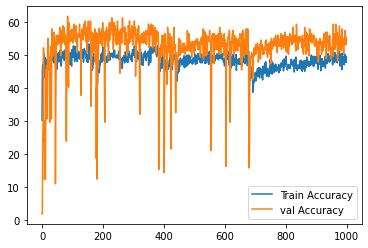

In [ ]:
plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(test_accuracy, label="val Accuracy")
plt.legend()
plt.show()

In [ ]:
accuracy_test = 0
model.eval()
model.load_state_dict(torch.load('/content/best_model_random_30_bands.pth')) #content/best_model_random_30.0_bands.pth
for x, y in val_dataloader:
  output = model(x, band_mask)
  accuracy_test += (nn.Softmax(dim=1)(output).argmax(1) == y.argmax(1)).float().sum()

test_acc = 100 * accuracy_test.item() / len(val_data)
print(f'Test Accuracy: {np.round(test_acc, 2)}%')

Test Accuracy: 53.35%


Random Band Dropout

In [ ]:
model = HSIClassification()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
epoch_loss = []
train_accuracy = []
test_accuracy = []
best_test = 0
for epoch in range(50000):
  batch_loss = []
  accuracy = 0
  model.train()
  for x, y in train_dataloader:
    optimizer.zero_grad()
    idx = random.sample(range(0, 200), 50)
    band_mask = torch.ones((1, 200))
    band_mask[0, idx] = 0
    # band_mask = torch.randint(0, 2, (1, 200))[0]
    
    output = model(x, band_mask)
    loss = loss_fn(output, y)
    accuracy += (nn.Softmax(dim=1)(output).argmax(1) == y.argmax(1)).float().sum()
    batch_loss.append(loss.item())

    loss.backward()
    optimizer.step()
  accuracy_test = 0
  model.eval()
  for x, y in test_dataloader:
    output = model(x)
    accuracy_test += (nn.Softmax(dim=1)(output).argmax(1) == y.argmax(1)).float().sum()
  if accuracy_test > best_test:
    best_test = accuracy_test
    torch.save(model.state_dict(), f"best_model_random_band_dropout.pth")
  loss = sum(batch_loss)/len(batch_loss)
  epoch_loss.append(loss)
  train_acc = 100 * accuracy.item() / len(training_data)
  train_accuracy.append(train_acc)
  test_acc = 100 * accuracy_test.item() / len(test_data)
  test_accuracy.append(test_acc)
  print(f'[{epoch+1}/50000] Average Loss: {np.round(loss, 4)}\t Train Accuracy: {np.round(train_acc, 2)}%\t Val Accuracy: {np.round(test_acc, 2)}%')

Streaming output truncated to the last 5000 lines.
[45001/50000] Average Loss: 1.2858	 Train Accuracy: 52.28%	 Val Accuracy: 17.7%
[45002/50000] Average Loss: 1.5289	 Train Accuracy: 50.6%	 Val Accuracy: 11.48%
[45003/50000] Average Loss: 1.4257	 Train Accuracy: 50.0%	 Val Accuracy: 10.53%
[45004/50000] Average Loss: 1.6852	 Train Accuracy: 50.12%	 Val Accuracy: 12.44%
[45005/50000] Average Loss: 1.6562	 Train Accuracy: 50.36%	 Val Accuracy: 16.27%
[45006/50000] Average Loss: 1.3052	 Train Accuracy: 49.16%	 Val Accuracy: 11.0%
[45007/50000] Average Loss: 1.4343	 Train Accuracy: 50.12%	 Val Accuracy: 18.18%
[45008/50000] Average Loss: 1.3352	 Train Accuracy: 49.04%	 Val Accuracy: 15.31%
[45009/50000] Average Loss: 1.4774	 Train Accuracy: 50.48%	 Val Accuracy: 15.31%
[45010/50000] Average Loss: 1.4009	 Train Accuracy: 51.08%	 Val Accuracy: 16.75%
[45011/50000] Average Loss: 1.3574	 Train Accuracy: 51.2%	 Val Accuracy: 12.44%
[45012/50000] Average Loss: 1.4381	 Train Accuracy: 51.32%	 Val

In [ ]:
print(f"Best val Accuracy (Random Band Dropout): {np.round(100 * best_test.item() / len(test_data), 2)}%")

Best val Accuracy (Random Band Dropout): 46.89%


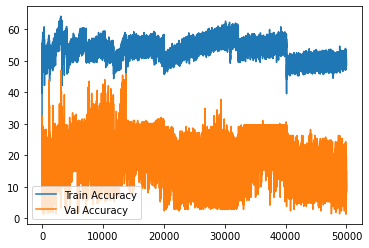

In [ ]:
plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(test_accuracy, label="Val Accuracy")
plt.legend()
plt.show()

In [ ]:
accuracy_test = 0
model.eval()
model.load_state_dict(torch.load('/content/best_model_random_band_dropout.pth')) #content/best_model_random_30.0_bands.pth
for x, y in val_dataloader:
  output = model(x)
  accuracy_test += (nn.Softmax(dim=1)(output).argmax(1) == y.argmax(1)).float().sum()

test_acc = 100 * accuracy_test.item() / len(val_data)
print(f'Test Accuracy: {np.round(test_acc, 2)}%')

Test Accuracy: 42.98%
